# K-Means Clustering for mnist dataset

## Import data

In [465]:
import numpy as np 
from tensorflow.keras.datasets import mnist
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tabulate import tabulate

In [466]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
print(train_y)

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
[5 0 4 ... 5 6 8]


In [467]:
train_X = train_X.reshape(len(train_X), 28*28)
test_X = test_X.reshape(len(test_X), 28*28)
print('X_train: ' + str(train_X.shape))
print('X_test:  '  + str(test_X.shape))

X_train: (60000, 784)
X_test:  (10000, 784)


In [468]:
train_X = train_X.astype('float32') 
test_X = test_X.astype('float32')

train_X = train_X/255.0
test_X = test_X/255.0

## Create K-Means Model with 10 clusters

In [469]:
from sklearn.cluster import MiniBatchKMeans

total_clusters = len(np.unique(test_y))
print(total_clusters)

kmeans_10 = MiniBatchKMeans(n_clusters = total_clusters)
kmeans_10.fit(train_X)

10


MiniBatchKMeans(n_clusters=10)

In [470]:
trains_pred_y = kmeans_10.predict(train_X)
print(train_y[0:20])
print(trains_pred_y[0:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[4 6 5 8 9 2 1 4 1 2 4 8 0 3 1 2 3 2 1 2]


In [471]:
def match_clusters(y, y_pred):
    reference_labels = {}
    for i in range(len(np.unique(y_pred))):
        index = np.where(y_pred == i,1,0)
        # print(i, np.bincount(y[index==1]))
        num = np.bincount(y[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [472]:
def match_clusters_swap(reference_labels, trains_pred_y):
    number_labels = np.array([0] * len(trains_pred_y))
    for i in range(len(trains_pred_y)):
        number_labels[i] = reference_labels[trains_pred_y[i]]
    return number_labels

In [473]:
reference_labels_10 = match_clusters(train_y, trains_pred_y)
print(reference_labels_10)

trains_pred_y_matched = match_clusters_swap(reference_labels_10, trains_pred_y)

print(train_y[0:20])
print(trains_pred_y_matched[0:20])

{0: 3, 1: 1, 2: 8, 3: 6, 4: 3, 5: 4, 6: 0, 7: 0, 8: 1, 9: 7}
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[3 0 4 1 7 8 1 3 1 8 3 1 3 6 1 8 6 8 1 8]


In [474]:
def print_stats (model, train_y, trains_pred_y):
    inertia = model.inertia_
    homogeneity = metrics.homogeneity_score(trains_pred_y, train_y)
    accuracy = accuracy_score(train_y, trains_pred_y)
    print('Inertia : ' + str(format(inertia)))
    print('Homogeneity : ' + str(homogeneity))
    print('Accuracy score : ' + str(accuracy))
    return (inertia, homogeneity, accuracy)

In [475]:
print("Train set stats")
train_inertia_10, train_homogeneity_10, train_accuracy_10 = print_stats(kmeans_10, train_y, trains_pred_y_matched)

print("\nTesting set stats")
test_pred_y = kmeans_10.predict(test_X)
test_pred_y_matched = match_clusters_swap(reference_labels_10, test_pred_y)
test_inertia_10, test_homogeneity_10, test_accuracy_10 = print_stats(kmeans_10, test_y, test_pred_y_matched)

Train set stats
Inertia : 2390509.25
Homogeneity : 0.4749064878937768
Accuracy score : 0.4744833333333333

Testing set stats
Inertia : 2390509.25
Homogeneity : 0.48491654113329946
Accuracy score : 0.4726


## Testing with different number of clusters

In [476]:
cluster_nums = [16, 32, 64, 128, 256]
models = []
reference_maps = []
train_inertias = []
train_homogeneities = []
train_accuracys = []
test_inertias = []
test_homogeneities = []
test_accuracys = []

for clust_num in cluster_nums:
    print("CLUSTERS: " + str(clust_num))
    kmeans_temp = MiniBatchKMeans(n_clusters = clust_num)
    kmeans_temp.fit(train_X)
    trains_pred_y = kmeans_temp.predict(train_X)

    reference_labels = match_clusters(train_y, trains_pred_y)

    trains_pred_y_matched = match_clusters_swap(reference_labels, trains_pred_y)

    print("Train set stats")
    train_inertia, train_homogeneity, train_accuracy = print_stats(kmeans_temp, train_y, trains_pred_y_matched)

    print("\nTesting set stats")
    test_pred_y = kmeans_temp.predict(test_X)
    test_pred_y_matched = match_clusters_swap(reference_labels, test_pred_y)
    test_inertia, test_homogeneity, test_accuracy = print_stats(kmeans_temp, test_y, test_pred_y_matched)
    print("\n")

    models.append(kmeans_temp)
    reference_maps.append(reference_labels)
    train_inertias.append(train_inertia)
    train_homogeneities.append(train_homogeneity)
    train_accuracys.append(train_accuracy)
    test_inertias.append(test_inertia)
    test_homogeneities.append(test_homogeneity)
    test_accuracys.append(test_accuracy)


    

CLUSTERS: 16
Train set stats
Inertia : 2216551.5
Homogeneity : 0.5416198096236198
Accuracy score : 0.64625

Testing set stats
Inertia : 2216551.5
Homogeneity : 0.5576404564106743
Accuracy score : 0.6532


CLUSTERS: 32
Train set stats
Inertia : 1988715.5
Homogeneity : 0.634008729156981
Accuracy score : 0.7330333333333333

Testing set stats
Inertia : 1988715.5
Homogeneity : 0.6480480913267076
Accuracy score : 0.738


CLUSTERS: 64
Train set stats
Inertia : 1804318.25
Homogeneity : 0.7088535123290066
Accuracy score : 0.8209166666666666

Testing set stats
Inertia : 1804318.25
Homogeneity : 0.7183656111522049
Accuracy score : 0.8249


CLUSTERS: 128
Train set stats
Inertia : 1647784.75
Homogeneity : 0.7611203826325377
Accuracy score : 0.8673333333333333

Testing set stats
Inertia : 1647784.75
Homogeneity : 0.7740236367869258
Accuracy score : 0.8767


CLUSTERS: 256
Train set stats
Inertia : 1505945.625
Homogeneity : 0.7954413392750959
Accuracy score : 0.8974833333333333

Testing set stats
Iner

### Summary of results

In [477]:
data = [[]]
data[0].append(10)
data[0].append(train_inertia_10)
data[0].append(train_homogeneity_10)
data[0].append(test_homogeneity_10)
data[0].append(train_accuracy_10)
data[0].append(test_accuracy_10)

for i in range(len(cluster_nums)):
    data.append([])
    data[i+1].append(cluster_nums[i])
    data[i+1].append(train_inertias[i])
    data[i+1].append(train_homogeneities[i])
    data[i+1].append(test_homogeneities[i])
    data[i+1].append(train_accuracys[i])
    data[i+1].append(test_accuracys[i])

#define header names
col_names = ["Number Clusters", "Model Inertia", "Train Homogeneity", "Test Homogeneity", "Train Accuracy", "Test Accuracy"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid", showindex="always"))


╒════╤═══════════════════╤═════════════════╤═════════════════════╤════════════════════╤══════════════════╤═════════════════╕
│    │   Number Clusters │   Model Inertia │   Train Homogeneity │   Test Homogeneity │   Train Accuracy │   Test Accuracy │
╞════╪═══════════════════╪═════════════════╪═════════════════════╪════════════════════╪══════════════════╪═════════════════╡
│  0 │                10 │     2.39051e+06 │            0.474906 │           0.484917 │         0.474483 │          0.4726 │
├────┼───────────────────┼─────────────────┼─────────────────────┼────────────────────┼──────────────────┼─────────────────┤
│  1 │                16 │     2.21655e+06 │            0.54162  │           0.55764  │         0.64625  │          0.6532 │
├────┼───────────────────┼─────────────────┼─────────────────────┼────────────────────┼──────────────────┼─────────────────┤
│  2 │                32 │     1.98872e+06 │            0.634009 │           0.648048 │         0.733033 │          0.738  │


## Visulaize Cluster Centers

Cluster centers for k-means with 10 clusters


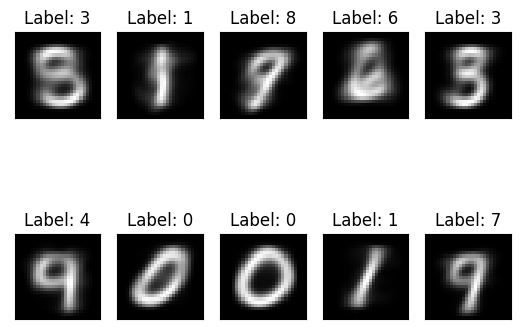

In [478]:
import matplotlib.pyplot as plt

centroids = kmeans_10.cluster_centers_.reshape((10, 28, 28))
print("Cluster centers for k-means with 10 clusters")

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(centroids[i], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(reference_labels_10[i]))
  plt.xticks([])
  plt.yticks([])

Cluster centers for k-means with 32 clusters


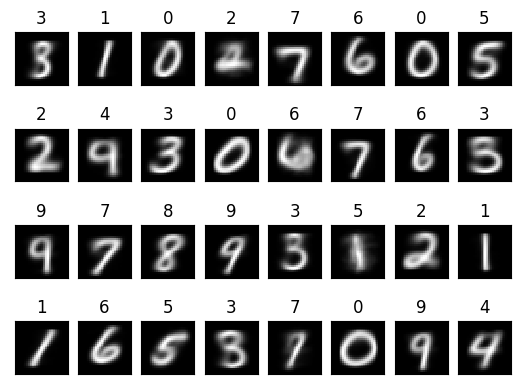

In [479]:
index = 1
cn = cluster_nums[index]
centroids = models[index].cluster_centers_.reshape((cn, 28, 28))
# print(centroids.shape)

print("Cluster centers for k-means with {} clusters".format(cn))

for i in range(cn):
  plt.subplot(4,8,i+1)
  plt.imshow(centroids[i], cmap='gray', interpolation='none')
  plt.title("{}".format(reference_maps[index][i]))
  plt.xticks([])
  plt.yticks([])

Cluster centers for k-means with 128 clusters


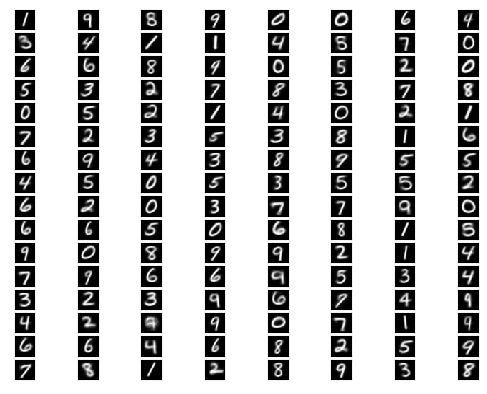

In [480]:
index = 3
cn = cluster_nums[index]
centroids = models[index].cluster_centers_.reshape((cn, 28, 28))
# print(centroids.shape)

print("Cluster centers for k-means with {} clusters".format(cn))

for i in range(cn):
  plt.subplot(16,8,i+1)
  plt.imshow(centroids[i], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])